In [1]:
from pecanpy import pecanpy as pp
import utils
import networkx as nx
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import json
from numpy.typing import NDArray
from typing import Dict
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_classif
from training import train_gnn
from torch_geometric.data import Data
import torch
import torch_geometric as pyg

%load_ext autoreload
%autoreload 2

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
def init_result_folder(path: str) -> nx.Graph:
    if not os.path.exists(os.path.join(path, 'results')):
        os.mkdir(os.path.join(path, 'results'))

    with open(os.path.join(path, 'results', 'results.json'), 'w') as f:
        json.dump(dict(), f)

    path_split = path.split('/')
    city_name = path_split[-1]
    data_dir = os.path.join(*path_split[:-1])
    graph, _ = utils.create_city_graph(city_name, data_dir)
    graph = nx.DiGraph(graph)

    mapping = {k: i for i, k in enumerate(sorted(graph.nodes()))}
    graph = nx.relabel_nodes(graph, mapping)

    path_edg_file = os.path.join(path, 'adj_mat.edg')
    nx.write_edgelist(graph, path_edg_file, data=False, delimiter='\t')

    return graph


def save_embeddings(path: str, p: float, q: float, num_walks: int, dim: int = 256) -> NDArray[np.float_]:
    path_edg_file = os.path.join(path, 'adj_mat.edg')

    g = pp.SparseOTF(p=p, q=q, verbose=False, workers=16)
    g.read_edg(path_edg_file, weighted=False, directed=True)

    embeddings = g.embed(dim=dim, num_walks=num_walks)

    np.save(os.path.join(path, 'results', 'node2vec_embeddings.npy'), embeddings)

    return embeddings


def train_svm(features: NDArray[np.float_], targets: NDArray[np.float_], seed: int = 42,scale_features=False) -> Dict:
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=seed)

    model = SVC(class_weight='balanced', C=1)
    if scale_features:
        standard_scaler = StandardScaler()
        standard_scaler.fit(X_train)
        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        score = f_classif(X_train,y_train)
        #print(score[0])

    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    results = {}
    results['train'] = classification_report(y_train, train_preds, output_dict=True)
    results['test'] = classification_report(y_test, test_preds, output_dict=True)

    return results


def cities_loop(data_path: str, p: float, q: float, num_walks: int, dim: int) -> None:

    for entry in os.scandir(data_path):
        if entry.is_dir():
            city = entry.name
            graph = init_result_folder(entry.path)
            embeddings = save_embeddings(entry.path, p, q, num_walks=num_walks, dim=dim)
            
            targets = dict(graph.nodes(data='city_center'))
            targets = np.array([targets[v] for v in range(len(targets))])
            
            results = train_svm(embeddings, targets)
            df_features = pd.read_csv(os.path.join(data_path,"handcrafted_features.csv"))
            df_features = df_features[df_features["city"]==city]
            targets_handcrafted = df_features["city_center"].values
            features_handcrafted = df_features.drop(["stop_I","name","city_center","city","Unnamed: 0"],axis=1)

            results_handcrafted =  train_svm(features_handcrafted, targets_handcrafted,scale_features=True)

            with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
                res_dict = json.load(f)
            print()
            res_dict['baseline_svm'] = results
            res_dict["handcrafted_svm"] = results_handcrafted

            with open(os.path.join(entry.path, 'results', 'results.json'), 'w') as f:
                json.dump(res_dict, f)


def cities_loop_gnn(data_path: str, seed: int = 42) -> None:

    for entry in os.scandir(data_path):
        if entry.is_dir():
            city = entry.name
            print(city)
            if city != 'turku':
                continue
            
            df_features = pd.read_csv(os.path.join(data_path,"handcrafted_features.csv"))
            df_features = df_features[df_features["city"]==city]
            targets_handcrafted = df_features["city_center"].values
            features_handcrafted = df_features.drop(["stop_I", "name", "city_center", "city","Unnamed: 0"],axis=1).values
            graph = nx.read_edgelist(os.path.join(entry.path, 'adj_mat.edg'), create_using=nx.DiGraph)

            print(targets_handcrafted.shape)
            print(features_handcrafted.shape)
            
            print(f'number of edges in nx graph : {graph.number_of_edges()}')
            adj_mat = nx.adjacency_matrix(graph, weight=None) # not weighted
            print(f'adj mat shape : {adj_mat.shape}')
            edge_index, _ = pyg.utils.from_scipy_sparse_matrix(adj_mat)
            print(f'adj mat shape sparse tensor : {edge_index.shape}')

            d = Data(
                x=torch.from_numpy(features_handcrafted),
                y=torch.tensor(targets_handcrafted, dtype=torch.float).clone(),
                edge_index=edge_index.clone(),
            )

            train_ids, test_ids = train_test_split(
                np.arange(features_handcrafted.shape[0]), test_size=0.2, stratify=targets_handcrafted, random_state=seed
            )

            train_ids, val_ids = train_test_split(
                train_ids, test_size=0.2, stratify=targets_handcrafted[train_ids], random_state=seed
            )

            pos_weight = np.sum(targets_handcrafted[train_ids] == 0) / np.sum(targets_handcrafted[train_ids] == 1)
            print(f'Pos weight : {pos_weight}')

            print(f'Training GNN...')
            # results_gnn = train_gnn(
            #     [d],
            #     train_ids,
            #     val_ids,
            #     test_ids,
            #     pos_weight=pos_weight,
            #     model_name='gnn',
            #     lr=1e-3,
            #     epochs=200,
            #     out_channels_graph=128,
            #     in_channels_graph=18,
            #     nb_graph_conv=5,
            #     dropout=0.0,

            # )
            print('*******************************')
            print(f'Training GAT...')
            results_gat = train_gnn(
                [d],
                train_ids,
                val_ids,
                test_ids,
                pos_weight=pos_weight,
                model_name='gat',
                lr=1e-3,
                epochs=200,
                out_channels_graph=16,
                in_channels_graph=18,
                heads=8,
                nb_graph_conv=3,
                dropout=0.0
            )
            break

            with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
                res_dict = json.load(f)
            print()
            res_dict['gnn'] = results_gnn
            res_dict["gat"] = results_gat

            with open(os.path.join(entry.path, 'results', 'results.json'), 'w') as f:
                json.dump(res_dict, f)

            print('***********************************************')
            print('***********************************************')
            break

In [65]:
cities_loop_gnn('data')

bordeaux
helsinki
rome
luxembourg
brisbane
canberra
nantes
kuopio
palermo
toulouse
berlin
rennes
sydney
turku
(1850,)
(1850, 18)
number of edges in nx graph : 2341
adj mat shape : (1850, 1850)
adj mat shape sparse tensor : torch.Size([2, 2341])
Pos weight : 4.5327102803738315
Training GNN...
*******************************
Training GAT...
Number of parameters in model : 80001


Epoch 1 / 200: 1it [00:00, 11.97it/s]


Avg. train loss of epoch 1 : 0.0021
Validation loss : 0.016151412113292796
Validation F1-score : 0.308139534883721
Validation recall-score : 0.9814814814814815
Validation precision-score : 0.18275862068965518


Epoch 2 / 200: 1it [00:00, 13.60it/s]


Avg. train loss of epoch 2 : 0.0040
Validation loss : 0.01165605557931436
Validation F1-score : 0.0625
Validation recall-score : 0.037037037037037035
Validation precision-score : 0.2


Epoch 3 / 200: 1it [00:00, 11.80it/s]


Avg. train loss of epoch 3 : 0.0022
Validation loss : 0.010549330228083843
Validation F1-score : 0.0625
Validation recall-score : 0.037037037037037035
Validation precision-score : 0.2


Epoch 4 / 200: 1it [00:00, 11.80it/s]


Avg. train loss of epoch 4 : 0.0021
Validation loss : 0.0072043989155743575
Validation F1-score : 0.23
Validation recall-score : 0.42592592592592593
Validation precision-score : 0.15753424657534246


Epoch 5 / 200: 1it [00:00, 10.47it/s]


Avg. train loss of epoch 5 : 0.0012
Validation loss : 0.008440995538556898
Validation F1-score : 0.29102167182662536
Validation recall-score : 0.8703703703703703
Validation precision-score : 0.17472118959107807


Epoch 6 / 200: 1it [00:00, 13.07it/s]


Avg. train loss of epoch 6 : 0.0017
Validation loss : 0.007437167135444847
Validation F1-score : 0.30769230769230765
Validation recall-score : 0.8518518518518519
Validation precision-score : 0.18775510204081633


Epoch 7 / 200: 1it [00:00, 10.60it/s]


Avg. train loss of epoch 7 : 0.0014
Validation loss : 0.007067757683831292
Validation F1-score : 0.20270270270270271
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.1595744680851064


Epoch 8 / 200: 1it [00:00, 11.89it/s]


Avg. train loss of epoch 8 : 0.0010
Validation loss : 0.008708218464980254
Validation F1-score : 0.08333333333333333
Validation recall-score : 0.05555555555555555
Validation precision-score : 0.16666666666666666


Epoch 9 / 200: 1it [00:00, 10.83it/s]


Avg. train loss of epoch 9 : 0.0013
Validation loss : 0.008216918320269198
Validation F1-score : 0.10126582278481013
Validation recall-score : 0.07407407407407407
Validation precision-score : 0.16


Epoch 10 / 200: 1it [00:00,  9.19it/s]


Avg. train loss of epoch 10 : 0.0012
Validation loss : 0.006753266663164706
Validation F1-score : 0.2209302325581395
Validation recall-score : 0.35185185185185186
Validation precision-score : 0.16101694915254236


Epoch 11 / 200: 1it [00:00,  8.96it/s]


Avg. train loss of epoch 11 : 0.0009
Validation loss : 0.006853913938676989
Validation F1-score : 0.2756183745583039
Validation recall-score : 0.7222222222222222
Validation precision-score : 0.1703056768558952


Epoch 12 / 200: 1it [00:00,  6.84it/s]

Avg. train loss of epoch 12 : 0.0010


Validation loss : 0.0069837997088561185
Validation F1-score : 0.2724252491694352
Validation recall-score : 0.7592592592592593
Validation precision-score : 0.1659919028340081


Epoch 13 / 200: 1it [00:00,  6.77it/s]

Avg. train loss of epoch 13 : 0.0011


Validation loss : 0.006547818312773833
Validation F1-score : 0.29149797570850206
Validation recall-score : 0.6666666666666666
Validation precision-score : 0.18652849740932642


Epoch 14 / 200: 1it [00:00,  8.75it/s]


Avg. train loss of epoch 14 : 0.0009
Validation loss : 0.006752451126639907
Validation F1-score : 0.16793893129770993
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.14285714285714285


Epoch 15 / 200: 1it [00:00,  9.44it/s]


Avg. train loss of epoch 15 : 0.0009
Validation loss : 0.00746548900733123
Validation F1-score : 0.13333333333333333
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.16666666666666666


Epoch 16 / 200: 1it [00:00,  9.03it/s]


Avg. train loss of epoch 16 : 0.0009
Validation loss : 0.007582881160684534
Validation F1-score : 0.12631578947368421
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.14634146341463414


Epoch 17 / 200: 1it [00:00,  8.99it/s]


Avg. train loss of epoch 17 : 0.0009
Validation loss : 0.007017962835930489
Validation F1-score : 0.19999999999999998
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.15625


Epoch 18 / 200: 1it [00:00, 10.82it/s]


Avg. train loss of epoch 18 : 0.0008
Validation loss : 0.006836021268689954
Validation F1-score : 0.28695652173913044
Validation recall-score : 0.6111111111111112
Validation precision-score : 0.1875


Epoch 19 / 200: 1it [00:00,  7.83it/s]


Avg. train loss of epoch 19 : 0.0008
Validation loss : 0.006906226680085466
Validation F1-score : 0.28685258964143423
Validation recall-score : 0.6666666666666666
Validation precision-score : 0.18274111675126903


Epoch 20 / 200: 1it [00:00,  4.03it/s]


Avg. train loss of epoch 20 : 0.0008
Validation loss : 0.006808253558906349
Validation F1-score : 0.27555555555555555
Validation recall-score : 0.5740740740740741
Validation precision-score : 0.18128654970760233


Epoch 21 / 200: 1it [00:00,  8.60it/s]


Avg. train loss of epoch 21 : 0.0008
Validation loss : 0.00669324236947137
Validation F1-score : 0.22222222222222224
Validation recall-score : 0.3148148148148148
Validation precision-score : 0.1717171717171717


Epoch 22 / 200: 1it [00:00,  8.72it/s]


Avg. train loss of epoch 22 : 0.0007
Validation loss : 0.0070263711181846825
Validation F1-score : 0.16071428571428573
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.15517241379310345


Epoch 23 / 200: 1it [00:00,  9.31it/s]


Avg. train loss of epoch 23 : 0.0007
Validation loss : 0.006131848773440799
Validation F1-score : 0.13333333333333333
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.13725490196078433


Epoch 24 / 200: 1it [00:00,  8.13it/s]


Avg. train loss of epoch 24 : 0.0007
Validation loss : 0.005658235904332754
Validation F1-score : 0.24427480916030533
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.2077922077922078


Epoch 25 / 200: 1it [00:00,  9.94it/s]


Avg. train loss of epoch 25 : 0.0007
Validation loss : 0.00532975873431644
Validation F1-score : 0.27118644067796616
Validation recall-score : 0.4444444444444444
Validation precision-score : 0.1951219512195122


Epoch 26 / 200: 1it [00:00,  7.13it/s]

Avg. train loss of epoch 26 : 0.0007


Validation loss : 0.0053982029895524725
Validation F1-score : 0.30414746543778803
Validation recall-score : 0.6111111111111112
Validation precision-score : 0.20245398773006135


Epoch 27 / 200: 1it [00:00,  6.27it/s]

Avg. train loss of epoch 27 : 0.0007


Validation loss : 0.005346389638411032
Validation F1-score : 0.29107981220657275
Validation recall-score : 0.5740740740740741
Validation precision-score : 0.1949685534591195


Epoch 28 / 200: 1it [00:00, 12.16it/s]


Avg. train loss of epoch 28 : 0.0007
Validation loss : 0.006274855217418155
Validation F1-score : 0.27380952380952384
Validation recall-score : 0.42592592592592593
Validation precision-score : 0.20175438596491227


Epoch 29 / 200: 1it [00:00,  6.82it/s]


Avg. train loss of epoch 29 : 0.0006
Validation loss : 0.006686557386372541
Validation F1-score : 0.24615384615384617
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.21052631578947367


Epoch 30 / 200: 1it [00:00,  7.46it/s]

Avg. train loss of epoch 30 : 0.0006


Validation loss : 0.0069288007310918855
Validation F1-score : 0.18018018018018017
Validation recall-score : 0.18518518518518517
Validation precision-score : 0.17543859649122806


Epoch 31 / 200: 1it [00:00,  9.28it/s]


Avg. train loss of epoch 31 : 0.0006
Validation loss : 0.006826845375267235
Validation F1-score : 0.17241379310344826
Validation recall-score : 0.18518518518518517
Validation precision-score : 0.16129032258064516


Epoch 32 / 200: 1it [00:00,  7.45it/s]

Avg. train loss of epoch 32 : 0.0006


Validation loss : 0.006566751244905833
Validation F1-score : 0.22222222222222224
Validation recall-score : 0.3148148148148148
Validation precision-score : 0.1717171717171717


Epoch 33 / 200: 1it [00:00,  3.68it/s]


Avg. train loss of epoch 33 : 0.0006
Validation loss : 0.00658297015203012
Validation F1-score : 0.2513089005235602
Validation recall-score : 0.4444444444444444
Validation precision-score : 0.17518248175182483


Epoch 34 / 200: 1it [00:00,  8.54it/s]


Avg. train loss of epoch 34 : 0.0006
Validation loss : 0.00645417015294771
Validation F1-score : 0.26262626262626265
Validation recall-score : 0.48148148148148145
Validation precision-score : 0.18055555555555555


Epoch 35 / 200: 1it [00:00,  7.89it/s]


Avg. train loss of epoch 35 : 0.0006
Validation loss : 0.00656767632510211
Validation F1-score : 0.23529411764705885
Validation recall-score : 0.37037037037037035
Validation precision-score : 0.1724137931034483


Epoch 36 / 200: 1it [00:00,  7.40it/s]


Avg. train loss of epoch 36 : 0.0006
Validation loss : 0.006811315948898728
Validation F1-score : 0.21739130434782608
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.17857142857142858


Epoch 37 / 200: 1it [00:00, 10.03it/s]


Avg. train loss of epoch 37 : 0.0006
Validation loss : 0.006978361993222623
Validation F1-score : 0.1788617886178862
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.15942028985507245


Epoch 38 / 200: 1it [00:00,  6.94it/s]


Avg. train loss of epoch 38 : 0.0006
Validation loss : 0.0069536566734313965
Validation F1-score : 0.23076923076923078
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.19736842105263158


Epoch 39 / 200: 1it [00:00, 12.11it/s]


Avg. train loss of epoch 39 : 0.0006
Validation loss : 0.006805414283597791
Validation F1-score : 0.27450980392156865
Validation recall-score : 0.3888888888888889
Validation precision-score : 0.21212121212121213


Epoch 40 / 200: 1it [00:00, 10.61it/s]


Avg. train loss of epoch 40 : 0.0005
Validation loss : 0.006710630816382331
Validation F1-score : 0.2696629213483146
Validation recall-score : 0.4444444444444444
Validation precision-score : 0.1935483870967742


Epoch 41 / 200: 1it [00:00,  8.22it/s]


Avg. train loss of epoch 41 : 0.0005
Validation loss : 0.006682857871055603
Validation F1-score : 0.26815642458100564
Validation recall-score : 0.4444444444444444
Validation precision-score : 0.192


Epoch 42 / 200: 1it [00:00, 10.57it/s]


Avg. train loss of epoch 42 : 0.0005
Validation loss : 0.006868015269975405
Validation F1-score : 0.29870129870129875
Validation recall-score : 0.42592592592592593
Validation precision-score : 0.23


Epoch 43 / 200: 1it [00:00,  8.59it/s]


Avg. train loss of epoch 43 : 0.0005
Validation loss : 0.007129321227202544
Validation F1-score : 0.2647058823529412
Validation recall-score : 0.3333333333333333
Validation precision-score : 0.21951219512195122


Epoch 44 / 200: 1it [00:00,  9.18it/s]


Avg. train loss of epoch 44 : 0.0005
Validation loss : 0.007287584446571968
Validation F1-score : 0.23333333333333334
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.21212121212121213


Epoch 45 / 200: 1it [00:00,  9.27it/s]


Avg. train loss of epoch 45 : 0.0005
Validation loss : 0.007233129965292441
Validation F1-score : 0.24
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.2112676056338028


Epoch 46 / 200: 1it [00:00,  7.61it/s]


Avg. train loss of epoch 46 : 0.0005
Validation loss : 0.007094025611877441
Validation F1-score : 0.23943661971830987
Validation recall-score : 0.3148148148148148
Validation precision-score : 0.19318181818181818


Epoch 47 / 200: 1it [00:00,  7.82it/s]


Avg. train loss of epoch 47 : 0.0005
Validation loss : 0.007028556353337056
Validation F1-score : 0.24691358024691354
Validation recall-score : 0.37037037037037035
Validation precision-score : 0.18518518518518517


Epoch 48 / 200: 1it [00:00, 10.59it/s]


Avg. train loss of epoch 48 : 0.0005
Validation loss : 0.007090756216564694
Validation F1-score : 0.22784810126582278
Validation recall-score : 0.3333333333333333
Validation precision-score : 0.17307692307692307


Epoch 49 / 200: 1it [00:00,  5.77it/s]


Avg. train loss of epoch 49 : 0.0005
Validation loss : 0.0073399809566704
Validation F1-score : 0.21276595744680854
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.1724137931034483


Epoch 50 / 200: 1it [00:00,  7.29it/s]


Avg. train loss of epoch 50 : 0.0005
Validation loss : 0.007499283229982531
Validation F1-score : 0.20155038759689925
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.17333333333333334


Epoch 51 / 200: 1it [00:00,  2.65it/s]


Avg. train loss of epoch 51 : 0.0005
Validation loss : 0.007587465080055031
Validation F1-score : 0.1904761904761905
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.16666666666666666


Epoch 52 / 200: 1it [00:00,  7.15it/s]


Avg. train loss of epoch 52 : 0.0005
Validation loss : 0.007518935042458611
Validation F1-score : 0.20437956204379562
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.1686746987951807


Epoch 53 / 200: 1it [00:00,  7.80it/s]


Avg. train loss of epoch 53 : 0.0005
Validation loss : 0.007439900894422789
Validation F1-score : 0.20512820512820515
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.1568627450980392


Epoch 54 / 200: 1it [00:00, 10.24it/s]


Avg. train loss of epoch 54 : 0.0004
Validation loss : 0.007459216021202706
Validation F1-score : 0.20512820512820515
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.1568627450980392


Epoch 55 / 200: 1it [00:00,  9.14it/s]


Avg. train loss of epoch 55 : 0.0004
Validation loss : 0.0075920949111113675
Validation F1-score : 0.19858156028368795
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.16091954022988506


Epoch 56 / 200: 1it [00:00, 12.56it/s]


Avg. train loss of epoch 56 : 0.0004
Validation loss : 0.007755849007013682
Validation F1-score : 0.2153846153846154
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.18421052631578946


Epoch 57 / 200: 1it [00:00,  8.72it/s]


Avg. train loss of epoch 57 : 0.0004
Validation loss : 0.00781190798089311
Validation F1-score : 0.208
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.18309859154929578


Epoch 58 / 200: 1it [00:00,  8.06it/s]


Avg. train loss of epoch 58 : 0.0004
Validation loss : 0.007727916176254685
Validation F1-score : 0.2058823529411765
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.17073170731707318


Epoch 59 / 200: 1it [00:00,  8.39it/s]


Avg. train loss of epoch 59 : 0.0004
Validation loss : 0.00762744529827221
Validation F1-score : 0.2162162162162162
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.1702127659574468


Epoch 60 / 200: 1it [00:00,  8.83it/s]


Avg. train loss of epoch 60 : 0.0004
Validation loss : 0.007630861288792378
Validation F1-score : 0.20134228187919462
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.15789473684210525


Epoch 61 / 200: 1it [00:00,  7.59it/s]


Avg. train loss of epoch 61 : 0.0004
Validation loss : 0.007750678706813503
Validation F1-score : 0.19858156028368795
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.16091954022988506


Epoch 62 / 200: 1it [00:00, 11.77it/s]


Avg. train loss of epoch 62 : 0.0004
Validation loss : 0.007950322853552329
Validation F1-score : 0.203125
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.17567567567567569


Epoch 63 / 200: 1it [00:00,  6.29it/s]

Avg. train loss of epoch 63 : 0.0004


Validation loss : 0.008037592108185226
Validation F1-score : 0.21311475409836064
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.19117647058823528


Epoch 64 / 200: 1it [00:00,  7.47it/s]

Avg. train loss of epoch 64 : 0.0004


Validation loss : 0.008021893533500465
Validation F1-score : 0.22222222222222224
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.18518518518518517


Epoch 65 / 200: 1it [00:00,  5.38it/s]


Avg. train loss of epoch 65 : 0.0004
Validation loss : 0.008012376927040718
Validation F1-score : 0.2318840579710145
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.19047619047619047


Epoch 66 / 200: 1it [00:00,  8.91it/s]


Avg. train loss of epoch 66 : 0.0004
Validation loss : 0.008092396968119853
Validation F1-score : 0.2074074074074074
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.1728395061728395


Epoch 67 / 200: 1it [00:00, 13.08it/s]


Avg. train loss of epoch 67 : 0.0004
Validation loss : 0.008248187400199272
Validation F1-score : 0.20155038759689925
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.17333333333333334


Epoch 68 / 200: 1it [00:00,  5.00it/s]


Avg. train loss of epoch 68 : 0.0004
Validation loss : 0.00838304532540811
Validation F1-score : 0.2113821138211382
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.18840579710144928


Epoch 69 / 200: 1it [00:00, 11.41it/s]


Avg. train loss of epoch 69 : 0.0003
Validation loss : 0.008404132482167837
Validation F1-score : 0.208
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.18309859154929578


Epoch 70 / 200: 1it [00:00,  8.19it/s]


Avg. train loss of epoch 70 : 0.0003
Validation loss : 0.008351880150872308
Validation F1-score : 0.19402985074626866
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.1625


Epoch 71 / 200: 1it [00:00,  9.27it/s]


Avg. train loss of epoch 71 : 0.0003
Validation loss : 0.008316243822510177
Validation F1-score : 0.19259259259259257
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.16049382716049382


Epoch 72 / 200: 1it [00:00,  9.22it/s]


Avg. train loss of epoch 72 : 0.0003
Validation loss : 0.008402204996830708
Validation F1-score : 0.2047244094488189
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.1780821917808219


Epoch 73 / 200: 1it [00:00, 10.13it/s]


Avg. train loss of epoch 73 : 0.0003
Validation loss : 0.008507613394711469
Validation F1-score : 0.21311475409836064
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.19117647058823528


Epoch 74 / 200: 1it [00:00, 13.51it/s]


Avg. train loss of epoch 74 : 0.0003
Validation loss : 0.008540115646413854
Validation F1-score : 0.22950819672131148
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.20588235294117646


Epoch 75 / 200: 1it [00:00, 10.10it/s]


Avg. train loss of epoch 75 : 0.0003
Validation loss : 0.008520299518430556
Validation F1-score : 0.265625
Validation recall-score : 0.3148148148148148
Validation precision-score : 0.22972972972972974


Epoch 76 / 200: 1it [00:00,  8.74it/s]


Avg. train loss of epoch 76 : 0.0003
Validation loss : 0.008547957684542681
Validation F1-score : 0.26153846153846155
Validation recall-score : 0.3148148148148148
Validation precision-score : 0.2236842105263158


Epoch 77 / 200: 1it [00:00,  6.04it/s]

Avg. train loss of epoch 77 : 0.0003


Validation loss : 0.008664228626199671
Validation F1-score : 0.25396825396825395
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.2222222222222222


Epoch 78 / 200: 1it [00:00,  7.77it/s]

Avg. train loss of epoch 78 : 0.0003


Validation loss : 0.008825807152567682
Validation F1-score : 0.25
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.22727272727272727


Epoch 79 / 200: 1it [00:00,  6.93it/s]

Avg. train loss of epoch 79 : 0.0003


Validation loss : 0.00898949520007984
Validation F1-score : 0.23333333333333334
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.21212121212121213


Epoch 80 / 200: 1it [00:00,  6.27it/s]

Avg. train loss of epoch 80 : 0.0003


Validation loss : 0.009051501750946045
Validation F1-score : 0.2622950819672131
Validation recall-score : 0.2962962962962963
Validation precision-score : 0.23529411764705882


Epoch 81 / 200: 1it [00:00,  6.70it/s]

Avg. train loss of epoch 81 : 0.0003


Validation loss : 0.009110835758415429
Validation F1-score : 0.24590163934426232
Validation recall-score : 0.2777777777777778
Validation precision-score : 0.22058823529411764


Epoch 82 / 200: 1it [00:00,  2.89it/s]


Avg. train loss of epoch 82 : 0.0003
Validation loss : 0.009156997944857623
Validation F1-score : 0.23333333333333334
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.21212121212121213


Epoch 83 / 200: 1it [00:00, 10.70it/s]


Avg. train loss of epoch 83 : 0.0003
Validation loss : 0.009239948279148823
Validation F1-score : 0.22608695652173913
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.21311475409836064


Epoch 84 / 200: 1it [00:00,  8.68it/s]


Avg. train loss of epoch 84 : 0.0003
Validation loss : 0.009295126876315556
Validation F1-score : 0.22033898305084745
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.203125


Epoch 85 / 200: 1it [00:00,  7.59it/s]


Avg. train loss of epoch 85 : 0.0003
Validation loss : 0.009332636723647246
Validation F1-score : 0.21666666666666662
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.19696969696969696


Epoch 86 / 200: 1it [00:00, 10.01it/s]


Avg. train loss of epoch 86 : 0.0003
Validation loss : 0.009423768198167955
Validation F1-score : 0.21487603305785125
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.19402985074626866


Epoch 87 / 200: 1it [00:00,  8.11it/s]


Avg. train loss of epoch 87 : 0.0003
Validation loss : 0.00955036040898916
Validation F1-score : 0.21666666666666662
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.19696969696969696


Epoch 88 / 200: 1it [00:00, 11.32it/s]


Avg. train loss of epoch 88 : 0.0003
Validation loss : 0.009640677555187329
Validation F1-score : 0.20512820512820512
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.19047619047619047


Epoch 89 / 200: 1it [00:00, 11.67it/s]


Avg. train loss of epoch 89 : 0.0002
Validation loss : 0.00968176851401458
Validation F1-score : 0.20689655172413793
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.1935483870967742


Epoch 90 / 200: 1it [00:00, 10.36it/s]


Avg. train loss of epoch 90 : 0.0002
Validation loss : 0.009729142124588424
Validation F1-score : 0.20869565217391306
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.19672131147540983


Epoch 91 / 200: 1it [00:00,  8.95it/s]


Avg. train loss of epoch 91 : 0.0002
Validation loss : 0.009826631159395785
Validation F1-score : 0.2280701754385965
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.21666666666666667


Epoch 92 / 200: 1it [00:00,  7.94it/s]


Avg. train loss of epoch 92 : 0.0002
Validation loss : 0.009890002173346442
Validation F1-score : 0.24347826086956523
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.22950819672131148


Epoch 93 / 200: 1it [00:00,  7.38it/s]

Avg. train loss of epoch 93 : 0.0002


Validation loss : 0.009909415567243422
Validation F1-score : 0.24137931034482757
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.22580645161290322


Epoch 94 / 200: 1it [00:00,  9.13it/s]


Avg. train loss of epoch 94 : 0.0002
Validation loss : 0.009964161628001445
Validation F1-score : 0.2393162393162393
Validation recall-score : 0.25925925925925924
Validation precision-score : 0.2222222222222222


Epoch 95 / 200: 1it [00:00,  9.56it/s]


Avg. train loss of epoch 95 : 0.0002
Validation loss : 0.010112378242853525
Validation F1-score : 0.22413793103448276
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.20967741935483872


Epoch 96 / 200: 1it [00:00, 11.21it/s]


Avg. train loss of epoch 96 : 0.0002
Validation loss : 0.010229213012231363
Validation F1-score : 0.22608695652173913
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.21311475409836064


Epoch 97 / 200: 1it [00:00,  6.99it/s]

Avg. train loss of epoch 97 : 0.0002


Validation loss : 0.01029333150064623
Validation F1-score : 0.22413793103448276
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.20967741935483872


Epoch 98 / 200: 1it [00:00, 11.60it/s]


Avg. train loss of epoch 98 : 0.0002
Validation loss : 0.010346928963790069
Validation F1-score : 0.20689655172413793
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.1935483870967742


Epoch 99 / 200: 1it [00:00,  6.85it/s]


Avg. train loss of epoch 99 : 0.0002
Validation loss : 0.010460724701752534
Validation F1-score : 0.20689655172413793
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.1935483870967742


Epoch 100 / 200: 1it [00:00, 12.66it/s]


Avg. train loss of epoch 100 : 0.0002
Validation loss : 0.01063623621657088
Validation F1-score : 0.1946902654867257
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.1864406779661017


Epoch 101 / 200: 1it [00:00,  7.17it/s]


Avg. train loss of epoch 101 : 0.0002
Validation loss : 0.010750058534983042
Validation F1-score : 0.19642857142857142
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.1896551724137931


Epoch 102 / 200: 1it [00:00, 10.38it/s]


Avg. train loss of epoch 102 : 0.0002
Validation loss : 0.010789926793124224
Validation F1-score : 0.1946902654867257
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.1864406779661017


Epoch 103 / 200: 1it [00:00,  6.93it/s]

Avg. train loss of epoch 103 : 0.0002


Validation loss : 0.010870308489412875
Validation F1-score : 0.19642857142857142
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.1896551724137931


Epoch 104 / 200: 1it [00:00,  7.41it/s]

Avg. train loss of epoch 104 : 0.0002


Validation loss : 0.011049104703439248
Validation F1-score : 0.19999999999999998
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19642857142857142


Epoch 105 / 200: 1it [00:00, 11.76it/s]


Avg. train loss of epoch 105 : 0.0002
Validation loss : 0.011171822612350052
Validation F1-score : 0.19999999999999998
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19642857142857142


Epoch 106 / 200: 1it [00:00,  7.86it/s]


Avg. train loss of epoch 106 : 0.0002
Validation loss : 0.011185054843490189
Validation F1-score : 0.19298245614035087
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.18333333333333332


Epoch 107 / 200: 1it [00:00,  8.20it/s]


Avg. train loss of epoch 107 : 0.0002
Validation loss : 0.011368314962129335
Validation F1-score : 0.1981981981981982
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19298245614035087


Epoch 108 / 200: 1it [00:00,  4.11it/s]


Avg. train loss of epoch 108 : 0.0002
Validation loss : 0.011657717260154517
Validation F1-score : 0.20560747663551404
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.20754716981132076


Epoch 109 / 200: 1it [00:00, 12.08it/s]


Avg. train loss of epoch 109 : 0.0002
Validation loss : 0.011673796015816766
Validation F1-score : 0.1981981981981982
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19298245614035087


Epoch 110 / 200: 1it [00:00,  9.12it/s]


Avg. train loss of epoch 110 : 0.0002
Validation loss : 0.01174922166643916
Validation F1-score : 0.1981981981981982
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19298245614035087


Epoch 111 / 200: 1it [00:00,  6.90it/s]

Avg. train loss of epoch 111 : 0.0002


Validation loss : 0.012020473544662064
Validation F1-score : 0.19999999999999998
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19642857142857142


Epoch 112 / 200: 1it [00:00,  7.79it/s]

Avg. train loss of epoch 112 : 0.0002


Validation loss : 0.012046764025817046
Validation F1-score : 0.2037037037037037
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2037037037037037


Epoch 113 / 200: 1it [00:00,  5.35it/s]


Avg. train loss of epoch 113 : 0.0002
Validation loss : 0.0122302859216123
Validation F1-score : 0.19999999999999998
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.19642857142857142


Epoch 114 / 200: 1it [00:00,  6.86it/s]


Avg. train loss of epoch 114 : 0.0002
Validation loss : 0.011372920629140493
Validation F1-score : 0.21818181818181817
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.21428571428571427


Epoch 115 / 200: 1it [00:00, 12.34it/s]


Avg. train loss of epoch 115 : 0.0002
Validation loss : 0.011368506663554424
Validation F1-score : 0.2201834862385321
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.21818181818181817


Epoch 116 / 200: 1it [00:00,  7.95it/s]


Avg. train loss of epoch 116 : 0.0001
Validation loss : 0.011368586404903515
Validation F1-score : 0.21818181818181817
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.21428571428571427


Epoch 117 / 200: 1it [00:00, 13.11it/s]


Avg. train loss of epoch 117 : 0.0001
Validation loss : 0.01152985724242958
Validation F1-score : 0.23636363636363636
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.23214285714285715


Epoch 118 / 200: 1it [00:00, 10.23it/s]


Avg. train loss of epoch 118 : 0.0001
Validation loss : 0.011839199710536647
Validation F1-score : 0.2222222222222222
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.2222222222222222


Epoch 119 / 200: 1it [00:00, 11.08it/s]


Avg. train loss of epoch 119 : 0.0001
Validation loss : 0.013357859205555272
Validation F1-score : 0.2385321100917431
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.23636363636363636


Epoch 120 / 200: 1it [00:00, 10.86it/s]


Avg. train loss of epoch 120 : 0.0001
Validation loss : 0.013344370030068062
Validation F1-score : 0.23636363636363636
Validation recall-score : 0.24074074074074073
Validation precision-score : 0.23214285714285715


Epoch 121 / 200: 1it [00:00, 10.86it/s]


Avg. train loss of epoch 121 : 0.0001
Validation loss : 0.013596333361960746
Validation F1-score : 0.2201834862385321
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.21818181818181817


Epoch 122 / 200: 1it [00:00,  7.71it/s]

Avg. train loss of epoch 122 : 0.0001
Validation loss : 0.013772424813863393


Validation F1-score : 0.2201834862385321
Validation recall-score : 0.2222222222222222
Validation precision-score : 0.21818181818181817


Epoch 123 / 200: 1it [00:00, 10.38it/s]


Avg. train loss of epoch 123 : 0.0001
Validation loss : 0.01400533560160044
Validation F1-score : 0.2037037037037037
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2037037037037037


Epoch 124 / 200: 1it [00:00, 15.48it/s]


Avg. train loss of epoch 124 : 0.0001
Validation loss : 0.014274266926017968
Validation F1-score : 0.2037037037037037
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2037037037037037


Epoch 125 / 200: 1it [00:00,  8.94it/s]


Avg. train loss of epoch 125 : 0.0001
Validation loss : 0.014516111966725942
Validation F1-score : 0.2037037037037037
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2037037037037037


Epoch 126 / 200: 1it [00:00,  9.20it/s]


Avg. train loss of epoch 126 : 0.0001
Validation loss : 0.014761546173611202
Validation F1-score : 0.2037037037037037
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2037037037037037


Epoch 127 / 200: 1it [00:00,  9.70it/s]


Avg. train loss of epoch 127 : 0.0001
Validation loss : 0.014941977488028037
Validation F1-score : 0.20183486238532114
Validation recall-score : 0.2037037037037037
Validation precision-score : 0.2


Epoch 128 / 200: 1it [00:00, 11.71it/s]


Avg. train loss of epoch 128 : 0.0001
Validation loss : 0.015375668938095504
Validation F1-score : 0.17142857142857143
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.17647058823529413


Epoch 129 / 200: 1it [00:00,  8.19it/s]


Avg. train loss of epoch 129 : 0.0001
Validation loss : 0.015536008654413996
Validation F1-score : 0.16822429906542055
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.16981132075471697


Epoch 130 / 200: 1it [00:00, 10.27it/s]


Avg. train loss of epoch 130 : 0.0001
Validation loss : 0.015832780180750666
Validation F1-score : 0.17142857142857143
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.17647058823529413


Epoch 131 / 200: 1it [00:00, 12.36it/s]


Avg. train loss of epoch 131 : 0.0001
Validation loss : 0.016160906972111883
Validation F1-score : 0.17142857142857143
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.17647058823529413


Epoch 132 / 200: 1it [00:00, 11.02it/s]


Avg. train loss of epoch 132 : 0.0001
Validation loss : 0.01641152356121991
Validation F1-score : 0.17142857142857143
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.17647058823529413


Epoch 133 / 200: 1it [00:00,  5.69it/s]

Avg. train loss of epoch 133 : 0.0001


Validation loss : 0.016963971627725137
Validation F1-score : 0.1584158415841584
Validation recall-score : 0.14814814814814814
Validation precision-score : 0.1702127659574468


Epoch 134 / 200: 1it [00:00,  8.08it/s]


Avg. train loss of epoch 134 : 0.0001
Validation loss : 0.01693749105608141
Validation F1-score : 0.17142857142857143
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.17647058823529413


Epoch 135 / 200: 1it [00:00,  9.04it/s]


Avg. train loss of epoch 135 : 0.0001
Validation loss : 0.01739087620296994
Validation F1-score : 0.15999999999999998
Validation recall-score : 0.14814814814814814
Validation precision-score : 0.17391304347826086


Epoch 136 / 200: 1it [00:00,  7.56it/s]


Avg. train loss of epoch 136 : 0.0001
Validation loss : 0.01733006174499924
Validation F1-score : 0.17307692307692307
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.18


Epoch 137 / 200: 1it [00:00, 10.50it/s]


Avg. train loss of epoch 137 : 0.0001
Validation loss : 0.01779194297017278
Validation F1-score : 0.1616161616161616
Validation recall-score : 0.14814814814814814
Validation precision-score : 0.17777777777777778


Epoch 138 / 200: 1it [00:00, 13.60it/s]


Avg. train loss of epoch 138 : 0.0001
Validation loss : 0.017999231815338135
Validation F1-score : 0.17647058823529413
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.1875


Epoch 139 / 200: 1it [00:00, 12.56it/s]


Avg. train loss of epoch 139 : 0.0001
Validation loss : 0.018263866772522796
Validation F1-score : 0.17647058823529413
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.1875


Epoch 140 / 200: 1it [00:00, 13.84it/s]


Avg. train loss of epoch 140 : 0.0001
Validation loss : 0.01877220901283058
Validation F1-score : 0.1443298969072165
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.16279069767441862


Epoch 141 / 200: 1it [00:00,  9.80it/s]


Avg. train loss of epoch 141 : 0.0001
Validation loss : 0.018828586952106374
Validation F1-score : 0.1923076923076923
Validation recall-score : 0.18518518518518517
Validation precision-score : 0.2


Epoch 142 / 200: 1it [00:00, 10.34it/s]


Avg. train loss of epoch 142 : 0.0001
Validation loss : 0.019264209914851834
Validation F1-score : 0.18
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.1956521739130435


Epoch 143 / 200: 1it [00:00,  8.59it/s]


Avg. train loss of epoch 143 : 0.0001
Validation loss : 0.019446795051162306
Validation F1-score : 0.19417475728155342
Validation recall-score : 0.18518518518518517
Validation precision-score : 0.20408163265306123


Epoch 144 / 200: 1it [00:00, 11.23it/s]


Avg. train loss of epoch 144 : 0.0001
Validation loss : 0.019692292084565032
Validation F1-score : 0.17647058823529413
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.1875


Epoch 145 / 200: 1it [00:00, 10.57it/s]


Avg. train loss of epoch 145 : 0.0001
Validation loss : 0.02020067782015414
Validation F1-score : 0.125
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.14285714285714285


Epoch 146 / 200: 1it [00:00,  8.58it/s]


Avg. train loss of epoch 146 : 0.0001
Validation loss : 0.02019257642127372
Validation F1-score : 0.19417475728155342
Validation recall-score : 0.18518518518518517
Validation precision-score : 0.20408163265306123


Epoch 147 / 200: 1it [00:00,  7.10it/s]


Avg. train loss of epoch 147 : 0.0001
Validation loss : 0.02098207699285971
Validation F1-score : 0.125
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.14285714285714285


Epoch 148 / 200: 1it [00:00,  7.03it/s]

Avg. train loss of epoch 148 : 0.0001
Validation loss : 0.020887700287071435


Validation F1-score : 0.17821782178217818
Validation recall-score : 0.16666666666666666
Validation precision-score : 0.19148936170212766


Epoch 149 / 200: 1it [00:00,  6.68it/s]

Avg. train loss of epoch 149 : 0.0001
Validation loss : 0.021474422635258856


Validation F1-score : 0.1414141414141414
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15555555555555556


Epoch 150 / 200: 1it [00:00,  5.48it/s]

Avg. train loss of epoch 150 : 0.0000


Validation loss : 0.02173399764138299
Validation F1-score : 0.1414141414141414
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15555555555555556


Epoch 151 / 200: 1it [00:00,  7.71it/s]


Avg. train loss of epoch 151 : 0.0000
Validation loss : 0.021838640844499744
Validation F1-score : 0.1414141414141414
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15555555555555556


Epoch 152 / 200: 1it [00:00,  4.20it/s]


Avg. train loss of epoch 152 : 0.0000
Validation loss : 0.02253683193309887
Validation F1-score : 0.1414141414141414
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15555555555555556


Epoch 153 / 200: 1it [00:00,  7.69it/s]


Avg. train loss of epoch 153 : 0.0000
Validation loss : 0.022380279528128134
Validation F1-score : 0.15686274509803924
Validation recall-score : 0.14814814814814814
Validation precision-score : 0.16666666666666666


Epoch 154 / 200: 1it [00:00,  9.46it/s]


Avg. train loss of epoch 154 : 0.0000
Validation loss : 0.023111720342893858
Validation F1-score : 0.12244897959183673
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13636363636363635


Epoch 155 / 200: 1it [00:00, 14.63it/s]


Avg. train loss of epoch 155 : 0.0000
Validation loss : 0.02319290831282332
Validation F1-score : 0.13999999999999999
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15217391304347827


Epoch 156 / 200: 1it [00:00,  7.06it/s]


Avg. train loss of epoch 156 : 0.0000
Validation loss : 0.02350567965894132
Validation F1-score : 0.13999999999999999
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15217391304347827


Epoch 157 / 200: 1it [00:00, 10.97it/s]


Avg. train loss of epoch 157 : 0.0000
Validation loss : 0.023977827381443332
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 158 / 200: 1it [00:00, 11.34it/s]


Avg. train loss of epoch 158 : 0.0000
Validation loss : 0.023810194956289756
Validation F1-score : 0.1359223300970874
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14285714285714285


Epoch 159 / 200: 1it [00:00,  8.45it/s]


Avg. train loss of epoch 159 : 0.0000
Validation loss : 0.024724526985271555
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 160 / 200: 1it [00:00, 10.76it/s]


Avg. train loss of epoch 160 : 0.0000
Validation loss : 0.024382873161419016
Validation F1-score : 0.1359223300970874
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14285714285714285


Epoch 161 / 200: 1it [00:00, 10.01it/s]


Avg. train loss of epoch 161 : 0.0000
Validation loss : 0.025073401025823644
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 162 / 200: 1it [00:00,  9.06it/s]


Avg. train loss of epoch 162 : 0.0000
Validation loss : 0.02535758791743098
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 163 / 200: 1it [00:00, 10.68it/s]


Avg. train loss of epoch 163 : 0.0000
Validation loss : 0.025333117794346164
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 164 / 200: 1it [00:00, 12.29it/s]


Avg. train loss of epoch 164 : 0.0000
Validation loss : 0.02604292212305842
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 165 / 200: 1it [00:00,  8.40it/s]


Avg. train loss of epoch 165 : 0.0000
Validation loss : 0.026095480532259553
Validation F1-score : 0.12244897959183673
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13636363636363635


Epoch 166 / 200: 1it [00:00,  8.62it/s]


Avg. train loss of epoch 166 : 0.0000
Validation loss : 0.02635015023721231
Validation F1-score : 0.12244897959183673
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13636363636363635


Epoch 167 / 200: 1it [00:00, 13.71it/s]


Avg. train loss of epoch 167 : 0.0000
Validation loss : 0.0269813279847841
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 168 / 200: 1it [00:00,  8.42it/s]


Avg. train loss of epoch 168 : 0.0000
Validation loss : 0.02677125866348679
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 169 / 200: 1it [00:00, 10.08it/s]


Avg. train loss of epoch 169 : 0.0000
Validation loss : 0.027376603435825656
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 170 / 200: 1it [00:00, 12.47it/s]


Avg. train loss of epoch 170 : 0.0000
Validation loss : 0.027650327295870393
Validation F1-score : 0.12371134020618559
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13953488372093023


Epoch 171 / 200: 1it [00:00,  6.22it/s]


Avg. train loss of epoch 171 : 0.0000
Validation loss : 0.026046201989457413
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 172 / 200: 1it [00:00,  7.41it/s]


Avg. train loss of epoch 172 : 0.0000
Validation loss : 0.025434804929269327
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 173 / 200: 1it [00:00,  7.78it/s]


Avg. train loss of epoch 173 : 0.0000
Validation loss : 0.025564147008431924
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 174 / 200: 1it [00:00, 11.36it/s]


Avg. train loss of epoch 174 : 0.0000
Validation loss : 0.025534578271814296
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 175 / 200: 1it [00:00,  4.61it/s]


Avg. train loss of epoch 175 : 0.0000
Validation loss : 0.025944909533938847
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 176 / 200: 1it [00:00, 11.85it/s]


Avg. train loss of epoch 176 : 0.0000
Validation loss : 0.025972250345590954
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 177 / 200: 1it [00:00, 11.40it/s]


Avg. train loss of epoch 177 : 0.0000
Validation loss : 0.026058322674519307
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 178 / 200: 1it [00:00, 10.41it/s]


Avg. train loss of epoch 178 : 0.0000
Validation loss : 0.026448449573001347
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 179 / 200: 1it [00:00, 10.64it/s]


Avg. train loss of epoch 179 : 0.0000
Validation loss : 0.026532276256664378
Validation F1-score : 0.1188118811881188
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.1276595744680851


Epoch 180 / 200: 1it [00:00, 10.04it/s]


Avg. train loss of epoch 180 : 0.0000
Validation loss : 0.026798129081726074
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 181 / 200: 1it [00:00,  6.71it/s]

Avg. train loss of epoch 181 : 0.0000


Validation loss : 0.027191377974845266
Validation F1-score : 0.12244897959183673
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13636363636363635


Epoch 182 / 200: 1it [00:00,  7.57it/s]

Avg. train loss of epoch 182 : 0.0000
Validation loss : 0.02730170778326086


Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 183 / 200: 1it [00:00, 10.61it/s]


Avg. train loss of epoch 183 : 0.0000
Validation loss : 0.027499418000917177
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 184 / 200: 1it [00:00,  9.43it/s]


Avg. train loss of epoch 184 : 0.0000
Validation loss : 0.02783936423224372
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 185 / 200: 1it [00:00,  8.89it/s]


Avg. train loss of epoch 185 : 0.0000
Validation loss : 0.028042058686952333
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 186 / 200: 1it [00:00,  8.83it/s]


Avg. train loss of epoch 186 : 0.0000
Validation loss : 0.02807703211500838
Validation F1-score : 0.1188118811881188
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.1276595744680851


Epoch 187 / 200: 1it [00:00, 10.98it/s]


Avg. train loss of epoch 187 : 0.0000
Validation loss : 0.02875009420755747
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 188 / 200: 1it [00:00,  9.41it/s]


Avg. train loss of epoch 188 : 0.0000
Validation loss : 0.029448354566419446
Validation F1-score : 0.12
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13043478260869565


Epoch 189 / 200: 1it [00:00, 12.38it/s]


Avg. train loss of epoch 189 : 0.0000
Validation loss : 0.030009417920499236
Validation F1-score : 0.1188118811881188
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.1276595744680851


Epoch 190 / 200: 1it [00:00, 11.75it/s]


Avg. train loss of epoch 190 : 0.0000
Validation loss : 0.03060661779867636
Validation F1-score : 0.1188118811881188
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.1276595744680851


Epoch 191 / 200: 1it [00:00, 11.69it/s]


Avg. train loss of epoch 191 : 0.0000
Validation loss : 0.03125666927646946
Validation F1-score : 0.12244897959183673
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13636363636363635


Epoch 192 / 200: 1it [00:00, 11.55it/s]


Avg. train loss of epoch 192 : 0.0000
Validation loss : 0.031703755662247944
Validation F1-score : 0.1212121212121212
Validation recall-score : 0.1111111111111111
Validation precision-score : 0.13333333333333333


Epoch 193 / 200: 1it [00:00, 12.17it/s]


Avg. train loss of epoch 193 : 0.0000
Validation loss : 0.03204971068614238
Validation F1-score : 0.13861386138613857
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14893617021276595


Epoch 194 / 200: 1it [00:00, 10.37it/s]


Avg. train loss of epoch 194 : 0.0000
Validation loss : 0.03240230921152476
Validation F1-score : 0.13861386138613857
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14893617021276595


Epoch 195 / 200: 1it [00:00, 14.01it/s]


Avg. train loss of epoch 195 : 0.0000
Validation loss : 0.03266672508136646
Validation F1-score : 0.13861386138613857
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14893617021276595


Epoch 196 / 200: 1it [00:00,  4.12it/s]


Avg. train loss of epoch 196 : 0.0000
Validation loss : 0.03285819453162116
Validation F1-score : 0.13861386138613857
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14893617021276595


Epoch 197 / 200: 1it [00:00,  8.37it/s]


Avg. train loss of epoch 197 : 0.0000
Validation loss : 0.03302262280438397
Validation F1-score : 0.13999999999999999
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15217391304347827


Epoch 198 / 200: 1it [00:00, 12.86it/s]


Avg. train loss of epoch 198 : 0.0000
Validation loss : 0.03319665547963735
Validation F1-score : 0.13999999999999999
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.15217391304347827


Epoch 199 / 200: 1it [00:00, 12.85it/s]


Avg. train loss of epoch 199 : 0.0000
Validation loss : 0.033314505138912716
Validation F1-score : 0.13861386138613857
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14893617021276595


Epoch 200 / 200: 1it [00:00,  9.58it/s]


Avg. train loss of epoch 200 : 0.0000
Validation loss : 0.03343478086832408
Validation F1-score : 0.13725490196078433
Validation recall-score : 0.12962962962962962
Validation precision-score : 0.14583333333333334
Best validation F1-score : 0.308139534883721


In [9]:
cities_loop("data",p=5.0, q=0.1, num_walks=100,dim=256)

/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [7]:

best_p = -1
best_q = -1
best_score = -1
attempts = []
for p in [0.1, 1.0, 5.0]:
    for q in [0.1, 0.5, 1.0, 2.0, 5.0]:
        f1_train = []
        f1_val = []
        for city in ["turku","detroit","paris","adelaide"]:
            print(f"starting training for {city} with p={p} and q={q}")
            city_name = city
            data_dir = 'data'
            graph, _ = utils.create_city_graph(city_name, data_dir)
            graph = nx.DiGraph(graph)

            mapping = {k: i for i, k in enumerate(sorted(graph.nodes()))}
            graph = nx.relabel_nodes(graph, mapping)

            path_edg_file = os.path.join(data_dir, city_name, 'adj_mat.edg')
            nx.write_edgelist(graph, path_edg_file, data=False, delimiter='\t')
            g = pp.SparseOTF(p=p, q=q, verbose=False, workers=16)
            g.read_edg(path_edg_file, weighted=False, directed=True)

            embeddings = g.embed(dim=256, num_walks=100)

            targets = dict(graph.nodes(data='city_center'))
            targets = np.array([targets[v] for v in range(len(targets))])
            X_train, X_test, y_train, y_test = train_test_split(embeddings, targets, test_size=0.2, stratify=targets,random_state=42)
            X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15,stratify=y_train,random_state=42)
            model = SVC(class_weight='balanced', C=1)
            model.fit(X_train, y_train)

            train_preds = model.predict(X_train)
            train_rep = classification_report(y_train, train_preds,output_dict=True)
            val_preds = model.predict(X_val)
            val_rep = classification_report(y_val, val_preds,output_dict=True)

            f1_train.append(train_rep["1"]["f1-score"])
            f1_val.append(val_rep["1"]["f1-score"])
           
        avg_f1_train = np.mean(f1_train)
        avg_f1_val = np.mean(f1_val)
        attempts.append({"p":p,"q":q,"score_train":avg_f1_train,"score_val":avg_f1_val})

        if avg_f1_val  > best_score:
            best_score = avg_f1_val
            best_p = p
            best_q = q
print(f"best parameters with p={best_p} and q={best_q} and f1 {best_score}")


starting training for turku with p=0.1 and q=0.1
starting training for detroit with p=0.1 and q=0.1
starting training for paris with p=0.1 and q=0.1
starting training for adelaide with p=0.1 and q=0.1
starting training for turku with p=0.1 and q=0.5
starting training for detroit with p=0.1 and q=0.5
starting training for paris with p=0.1 and q=0.5
starting training for adelaide with p=0.1 and q=0.5
starting training for turku with p=0.1 and q=1.0
starting training for detroit with p=0.1 and q=1.0
starting training for paris with p=0.1 and q=1.0
starting training for adelaide with p=0.1 and q=1.0
starting training for turku with p=0.1 and q=2.0
starting training for detroit with p=0.1 and q=2.0
starting training for paris with p=0.1 and q=2.0
starting training for adelaide with p=0.1 and q=2.0
starting training for turku with p=0.1 and q=5.0
starting training for detroit with p=0.1 and q=5.0
starting training for paris with p=0.1 and q=5.0
starting training for adelaide with p=0.1 and q

In [72]:

import random

model_attempts = []

seed = 42

for model_name in ['gat', 'gnn']:
    best_heads = -1
    best_nb_graph_conv = -1
    best_out_channels = -1
    best_score = -1
    attempts = []

    if model_name == 'gat':
        heads = [2, 4, 8]
        nb_convs = [3, 5]
        out_channels = [8, 16, 32]
    else:
        heads = [0]
        nb_convs = [3, 5, 10]
        out_channels = [16, 32, 64, 128]
    for head in heads:
        for nb_conv in nb_convs:
            for out_channel in out_channels:
                f1_train = []
                f1_val = []
                for city in ["turku","detroit","paris","adelaide"]:

                    random.seed(seed)
                    np.random.seed(seed)
                    torch.manual_seed(seed)
                    torch.cuda.manual_seed_all(seed)
                    print(f"starting training for {city} with model_name={model_name}, head={head}, nb_conv={nb_conv}, out_channels={out_channel}")
                    city_name = city
                    data_dir = 'data'
                    df_features = pd.read_csv(os.path.join(data_dir,"handcrafted_features.csv"))
                    df_features = df_features[df_features["city"]==city]
                    targets_handcrafted = df_features["city_center"].values
                    features_handcrafted = df_features.drop(["stop_I", "name", "city_center", "city","Unnamed: 0"],axis=1).values
                    graph = nx.read_edgelist(os.path.join(data_dir, city_name, 'adj_mat.edg'), create_using=nx.DiGraph)

                    adj_mat = nx.adjacency_matrix(graph, weight=None) # not weighted
                    edge_index, _ = pyg.utils.from_scipy_sparse_matrix(adj_mat)
                    d = Data(
                        x=torch.from_numpy(features_handcrafted),
                        y=torch.tensor(targets_handcrafted, dtype=torch.float).clone(),
                        edge_index=edge_index.clone(),
                    )

                    train_ids, test_ids = train_test_split(
                        np.arange(features_handcrafted.shape[0]), test_size=0.2, stratify=targets_handcrafted, random_state=seed
                    )

                    train_ids, val_ids = train_test_split(
                        train_ids, test_size=0.2, stratify=targets_handcrafted[train_ids], random_state=seed
                    )

                    pos_weight = np.sum(targets_handcrafted[train_ids] == 0) / np.sum(targets_handcrafted[train_ids] == 1)

                    results_gat = train_gnn(
                        [d],
                        train_ids,
                        val_ids,
                        test_ids,
                        pos_weight=pos_weight,
                        model_name=model_name,
                        lr=1e-3,
                        epochs=200,
                        out_channels_graph=out_channel,
                        in_channels_graph=18,
                        heads=head,
                        nb_graph_conv=nb_conv,
                        dropout=0.0
                    )

                    f1_train.append(results_gat[0]['train']["1"]["f1-score"])
                    f1_val.append(results_gat[1])
                
                avg_f1_train = np.mean(f1_train)
                avg_f1_val = np.mean(f1_val)
                attempts.append({"model_name":model_name,"head":head,"nb_conv":nb_conv,"out_channel":out_channel,"train_f1": avg_f1_train, "val_f1": avg_f1_val})

                if avg_f1_val  > best_score:
                    best_score = avg_f1_val
                    best_heads = head
                    best_nb_graph_conv = nb_conv
                    best_out_channels = out_channel

    print(f"best parameters with model_name={model_name}, head={best_heads}, nb_conv={best_nb_graph_conv}, out_channels={best_out_channels}")
    model_attempts.append(attempts)


starting training for turku with model_name=gat, head=2, nb_conv=3, out_channels=8
starting training for detroit with model_name=gat, head=2, nb_conv=3, out_channels=8
starting training for paris with model_name=gat, head=2, nb_conv=3, out_channels=8
starting training for adelaide with model_name=gat, head=2, nb_conv=3, out_channels=8
starting training for turku with model_name=gat, head=2, nb_conv=3, out_channels=16
starting training for detroit with model_name=gat, head=2, nb_conv=3, out_channels=16
starting training for paris with model_name=gat, head=2, nb_conv=3, out_channels=16
starting training for adelaide with model_name=gat, head=2, nb_conv=3, out_channels=16
starting training for turku with model_name=gat, head=2, nb_conv=3, out_channels=32
starting training for detroit with model_name=gat, head=2, nb_conv=3, out_channels=32
starting training for paris with model_name=gat, head=2, nb_conv=3, out_channels=32
starting training for adelaide with model_name=gat, head=2, nb_conv=

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

starting training for turku with model_name=gat, head=4, nb_conv=5, out_channels=16
starting training for detroit with model_name=gat, head=4, nb_conv=5, out_channels=16
starting training for paris with model_name=gat, head=4, nb_conv=5, out_channels=16
starting training for adelaide with model_name=gat, head=4, nb_conv=5, out_channels=16
starting training for turku with model_name=gat, head=4, nb_conv=5, out_channels=32


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gat, head=4, nb_conv=5, out_channels=32
starting training for paris with model_name=gat, head=4, nb_conv=5, out_channels=32
starting training for adelaide with model_name=gat, head=4, nb_conv=5, out_channels=32
starting training for turku with model_name=gat, head=8, nb_conv=3, out_channels=8
starting training for detroit with model_name=gat, head=8, nb_conv=3, out_channels=8
starting training for paris with model_name=gat, head=8, nb_conv=3, out_channels=8
starting training for adelaide with model_name=gat, head=8, nb_conv=3, out_channels=8
starting training for turku with model_name=gat, head=8, nb_conv=3, out_channels=16
starting training for detroit with model_name=gat, head=8, nb_conv=3, out_channels=16
starting training for paris with model_name=gat, head=8, nb_conv=3, out_channels=16
starting training for adelaide with model_name=gat, head=8, nb_conv=3, out_channels=16
starting training for turku with model_name=gat, head=8, nb_conv=

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages

starting training for detroit with model_name=gat, head=8, nb_conv=3, out_channels=32


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for paris with model_name=gat, head=8, nb_conv=3, out_channels=32


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for adelaide with model_name=gat, head=8, nb_conv=3, out_channels=32


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for turku with model_name=gat, head=8, nb_conv=5, out_channels=8
starting training for detroit with model_name=gat, head=8, nb_conv=5, out_channels=8
starting training for paris with model_name=gat, head=8, nb_conv=5, out_channels=8
starting training for adelaide with model_name=gat, head=8, nb_conv=5, out_channels=8
starting training for turku with model_name=gat, head=8, nb_conv=5, out_channels=16


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gat, head=8, nb_conv=5, out_channels=16
starting training for paris with model_name=gat, head=8, nb_conv=5, out_channels=16
starting training for adelaide with model_name=gat, head=8, nb_conv=5, out_channels=16
starting training for turku with model_name=gat, head=8, nb_conv=5, out_channels=32


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gat, head=8, nb_conv=5, out_channels=32
starting training for paris with model_name=gat, head=8, nb_conv=5, out_channels=32
starting training for adelaide with model_name=gat, head=8, nb_conv=5, out_channels=32
best parameters with model_name=gat, head=8, nb_conv=5, out_channels=32
starting training for turku with model_name=gnn, head=0, nb_conv=3, out_channels=16
starting training for detroit with model_name=gnn, head=0, nb_conv=3, out_channels=16
starting training for paris with model_name=gnn, head=0, nb_conv=3, out_channels=16
starting training for adelaide with model_name=gnn, head=0, nb_conv=3, out_channels=16
starting training for turku with model_name=gnn, head=0, nb_conv=3, out_channels=32
starting training for detroit with model_name=gnn, head=0, nb_conv=3, out_channels=32
starting training for paris with model_name=gnn, head=0, nb_conv=3, out_channels=32
starting training for adelaide with model_name=gnn, head=0, nb_conv=3, out_c

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gnn, head=0, nb_conv=3, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for paris with model_name=gnn, head=0, nb_conv=3, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for adelaide with model_name=gnn, head=0, nb_conv=3, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for turku with model_name=gnn, head=0, nb_conv=5, out_channels=16
starting training for detroit with model_name=gnn, head=0, nb_conv=5, out_channels=16
starting training for paris with model_name=gnn, head=0, nb_conv=5, out_channels=16
starting training for adelaide with model_name=gnn, head=0, nb_conv=5, out_channels=16
starting training for turku with model_name=gnn, head=0, nb_conv=5, out_channels=32
starting training for detroit with model_name=gnn, head=0, nb_conv=5, out_channels=32
starting training for paris with model_name=gnn, head=0, nb_conv=5, out_channels=32
starting training for adelaide with model_name=gnn, head=0, nb_conv=5, out_channels=32
starting training for turku with model_name=gnn, head=0, nb_conv=5, out_channels=64
starting training for detroit with model_name=gnn, head=0, nb_conv=5, out_channels=64
starting training for paris with model_name=gnn, head=0, nb_conv=5, out_channels=64
starting training for adelaide with model_name=gnn, head=0, nb_c

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gnn, head=0, nb_conv=5, out_channels=128
starting training for paris with model_name=gnn, head=0, nb_conv=5, out_channels=128
starting training for adelaide with model_name=gnn, head=0, nb_conv=5, out_channels=128
starting training for turku with model_name=gnn, head=0, nb_conv=10, out_channels=16
starting training for detroit with model_name=gnn, head=0, nb_conv=10, out_channels=16
starting training for paris with model_name=gnn, head=0, nb_conv=10, out_channels=16
starting training for adelaide with model_name=gnn, head=0, nb_conv=10, out_channels=16
starting training for turku with model_name=gnn, head=0, nb_conv=10, out_channels=32
starting training for detroit with model_name=gnn, head=0, nb_conv=10, out_channels=32
starting training for paris with model_name=gnn, head=0, nb_conv=10, out_channels=32
starting training for adelaide with model_name=gnn, head=0, nb_conv=10, out_channels=32
starting training for turku with model_name=gnn, h

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gnn, head=0, nb_conv=10, out_channels=64
starting training for paris with model_name=gnn, head=0, nb_conv=10, out_channels=64


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for adelaide with model_name=gnn, head=0, nb_conv=10, out_channels=64
starting training for turku with model_name=gnn, head=0, nb_conv=10, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for detroit with model_name=gnn, head=0, nb_conv=10, out_channels=128
starting training for paris with model_name=gnn, head=0, nb_conv=10, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


starting training for adelaide with model_name=gnn, head=0, nb_conv=10, out_channels=128


/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages

best parameters with model_name=gnn, head=0, nb_conv=3, out_channels=128


In [73]:
import json
with open("save_gnns.json","w") as f:
    json.dump(model_attempts,f)

In [211]:
embeddings.shape

(1850, 256)

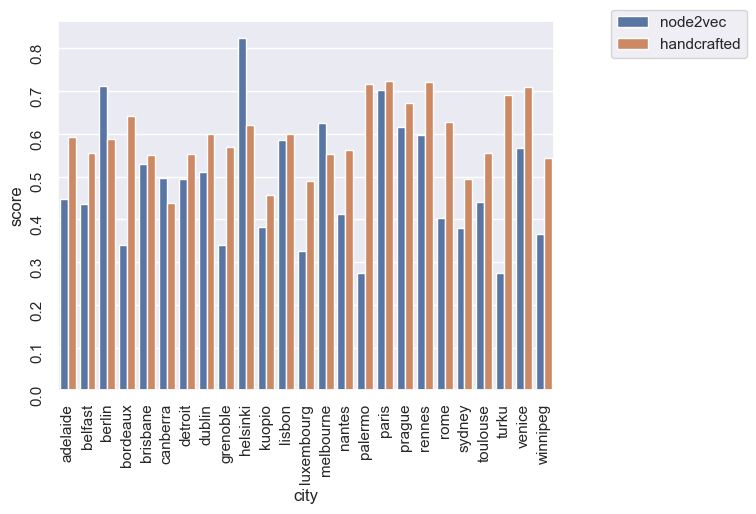

In [17]:
import seaborn as sns
lst = []
for entry in sorted(os.scandir("data"),key=lambda x: x.name):
    if entry.is_dir():
        city = entry.name
        with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
            res_dict = json.load(f)

        lst.append((city,"node2vec",res_dict["baseline_svm"]["test"]["1"]["f1-score"]))
        lst.append((city,"handcrafted",res_dict["handcrafted_svm"]["test"]["1"]["f1-score"]))
df = pd.DataFrame(lst,columns=["city","type","score"])
ax = sns.barplot(df, x="city",y="score",hue="type")
ax.tick_params(labelrotation=90) 
ax.legend(bbox_to_anchor=(1.1, 1.05),loc="upper left")

SVC(C=1, class_weight='balanced')

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1212
           1       0.49      0.90      0.63       268

    accuracy                           0.81      1480
   macro avg       0.73      0.85      0.75      1480
weighted avg       0.88      0.81      0.83      1480



              precision    recall  f1-score   support

           0       0.82      0.67      0.74       303
           1       0.18      0.33      0.23        67

    accuracy                           0.61       370
   macro avg       0.50      0.50      0.49       370
weighted avg       0.70      0.61      0.65       370

